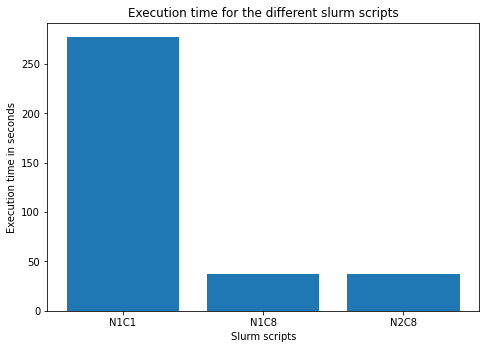

In [1]:
results = [277.502371,37.546311, 37.092691]
labels = ["N1C1", "N1C8", "N2C8"]

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,results)
ax.set_title('Execution time for the different slurm scripts')
ax.set_ylabel('Execution time in seconds')
ax.set_xlabel('Slurm scripts')
plt.show()

In [31]:
import json
def SydGrid(file_name):
    '''
    "geo":{"type":"Point","coordinates":[-33.86751,151.20797]}
    all 8 acesss and read same time
    datastructures to optimize performance
    showq -q snowy| less
    master has rank 0 always
    sbatch <script_name> 
    squeue -u <username>
    module avail mpip4py//list all libs
    tell module load <lib> in slurm script
    scancel <job_id>
    '''
    syd_grid = []
    with open(file_name) as f:
        data = json.load(f)
        for val in data['features']:
            grid_data = {}
            properties = val['properties']
            grid_data['id'] = properties['id']
            num = int((grid_data['id'])%4)
            if num == 0:
                num=4
            grid_data['cell'] = chr(int(num+64))+str(int((grid_data['id']-1)/4)+1)
            geometry = val['geometry'] 
            grid_data['xmin'] = geometry['coordinates'][0][0][0]
            grid_data['ymin'] = geometry['coordinates'][0][2][1]
            grid_data['xmax'] = geometry['coordinates'][0][1][0]
            grid_data['ymax'] = geometry['coordinates'][0][0][1]
            syd_grid.append(grid_data)
    return syd_grid

def GetGridCell(x,y):
    grid = SydGrid('./sydGrid.json')
    for item in grid:
        if item['xmin']<x<=item['xmax'] and item['ymin']<y<=item['ymax']:
            print(item['cell'])
            return
    print("None")
    
with open("./smallTwitter.json", encoding = "utf-8") as f:
    data = json.load(f)

counter = 0
for item in data['rows']:
    if item['doc']['geo'] is not None:
        counter +=1
        print(item['doc']['geo']['coordinates'])
        GetGridCell(item['doc']['geo']['coordinates'][1], item['doc']['geo']['coordinates'][0])
print(counter)
grid = SydGrid('./sydGrid.json')
for item in grid:
    print(item)

[-33.86, 151.211]
C3
[-33.86751, 151.20797]
C3
[-33.9005, 151.27053]
C3
[-33.93467816, 151.17834389]
C3
[-33.8473998, 151.072247]
C3
[-33.86751, 151.20797]
C3
[-33.81967, 151.0655]
C3
[-33.85999135, 151.2102003]
C3
[-33.86751, 151.20797]
C3
[-33.86751, 151.20797]
C3
[-33.8392224, 151.0355168]
C3
[-33.86751, 151.20797]
C3
[-33.86751, 151.20797]
C3
[-33.84371259, 151.2083274]
C3
[-33.8705799, 151.20747]
C3
15
{'id': 1, 'cell': 'A1', 'xmin': 149.79255080532937, 'ymin': -33.31644989181766, 'xmax': 150.34255080532938, 'ymax': -32.81644989181766}
{'id': 2, 'cell': 'B1', 'xmin': 149.79255080532937, 'ymin': -33.81644989181766, 'xmax': 150.34255080532938, 'ymax': -33.31644989181766}
{'id': 3, 'cell': 'C1', 'xmin': 149.79255080532937, 'ymin': -34.31644989181766, 'xmax': 150.34255080532938, 'ymax': -33.81644989181766}
{'id': 4, 'cell': 'D1', 'xmin': 149.79255080532937, 'ymin': -34.81644989181766, 'xmax': 150.34255080532938, 'ymax': -34.31644989181766}
{'id': 5, 'cell': 'A2', 'xmin': 150.342550805